In [109]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # fancy statistics plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import geopandas as gpd
import scipy
from scipy.optimize import curve_fit
import datetime


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/covid19-tracking-germany/de_county.shx
/kaggle/input/covid19-tracking-germany/demographics_de.csv
/kaggle/input/covid19-tracking-germany/de_county.shp
/kaggle/input/covid19-tracking-germany/de_state.shp
/kaggle/input/covid19-tracking-germany/de_county.dbf
/kaggle/input/covid19-tracking-germany/de_state.prj
/kaggle/input/covid19-tracking-germany/covid_de.csv
/kaggle/input/covid19-tracking-germany/de_state.dbf
/kaggle/input/covid19-tracking-germany/de_county.cpg
/kaggle/input/covid19-tracking-germany/de_state.shx
/kaggle/input/covid19-tracking-germany/de_state.cpg
/kaggle/input/covid19-tracking-germany/de_county.prj


In [110]:
path_to_file_covid = '../input/covid19-tracking-germany/covid_de.csv'
path_to_file_demo  = '../input/covid19-tracking-germany/demographics_de.csv'
path_to_file_shape = '../input/covid19-tracking-germany/de_state.shp'

#getting the data
covid_de  = pd.read_csv(path_to_file_covid, index_col="date", parse_dates=True) #cases and deaths per state and age and sex
demo_de   = pd.read_csv(path_to_file_demo)    # demography file
shape_de2 = gpd.read_file(path_to_file_shape) # geography file

# replace Umlaute
shape_tmp = shape_de2.replace({'Baden-Württemberg' : 'Baden-Wuerttemberg', 'Thüringen' : 'Thueringen' }).copy()
shape_de = shape_tmp.rename(columns={'GEN': 'state'}).copy()

# conversion factor for later
m2tokm2 = 1/1000000

In [111]:
covid_de

,state,county,age_group,gender,cases,deaths,recovered
date,,,,,,,
2020-03-27,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-03-28,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-04-03,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-10-18,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-10-22,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,0
...,...,...,...,...,...,...,...
2020-04-01,Thueringen,SK Weimar,80-99,M,1,0,1
2020-09-12,Thueringen,SK Weimar,80-99,M,1,0,1
2020-10-30,Thueringen,SK Weimar,80-99,M,1,0,1


In [112]:
demo_de.head()

,state,gender,age_group,population
0,Baden-Wuerttemberg,female,00-04,261674
1,Baden-Wuerttemberg,female,05-14,490822
2,Baden-Wuerttemberg,female,15-34,1293488
3,Baden-Wuerttemberg,female,35-59,1919649
4,Baden-Wuerttemberg,female,60-79,1182736


In [113]:
# Set the coordinate reference system (CRS) to EPSG 3035
# Lambert Azimuthal Equal Area -> 3035
shape_de.crs = {'init': 'epsg:3025'}
# print(shape_de.geometry.crs)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Bevölkerung und Bevölkerungsdichte

Es lässt sich damit die unterschiedlichen Bevölkerungs- und Bevölkerungsdichten der Staaten visualisieren. Der Bereich für die Dichteberechnung kann auch aus der Geometriedatei extrahiert werden. Das Gebiet wird in km ** 2 umgerechnet

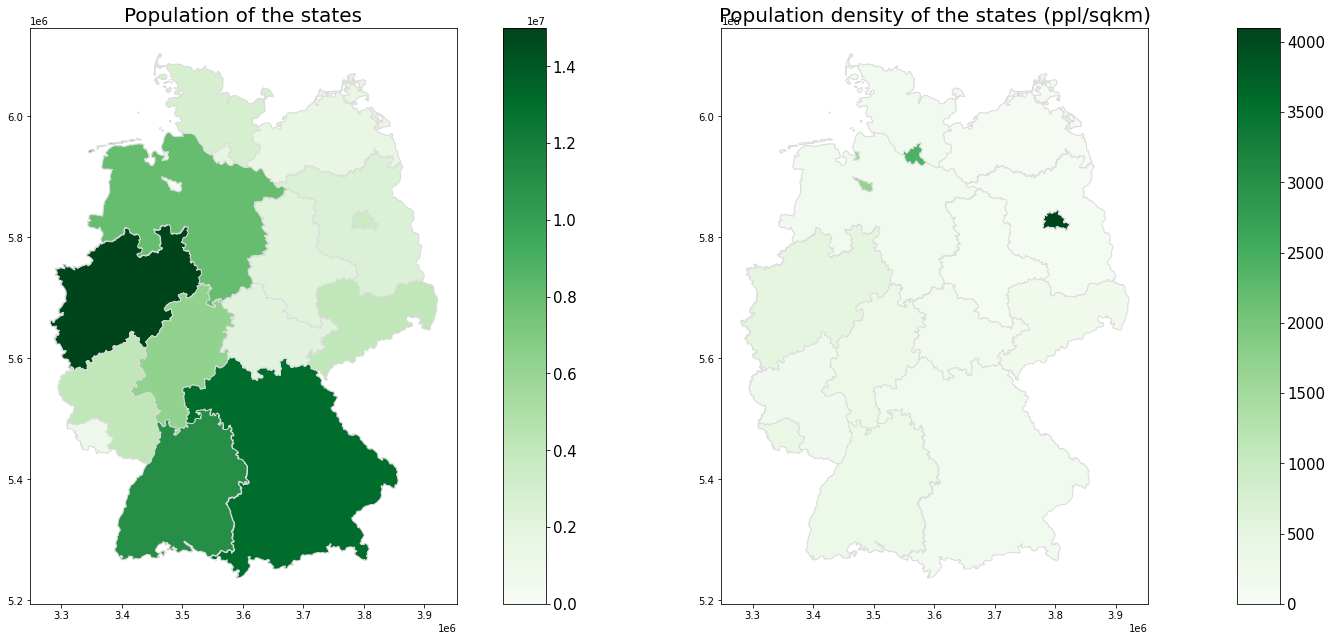

In [114]:
norm_axis1 = 15e6
norm_axis2 = 4.1e3


# map with population
def add_pop_state(state):
    popu = demo_de[demo_de.state == state].population.sum()
    #print(popu)
    shape_de[shape_de.state == state].plot(figsize=(10,10),color= cm.Greens(popu/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

#map with population density
# for this get the area from the polygon, i.e. geometry
def get_area(state):   
    return shape_de[shape_de.state == state].geometry.area

def add_dens_state(state):
    dens  = demo_de[demo_de.state == state].population.sum()/float(get_area(state))/(m2tokm2)
    #print(state , '----' , round((dens)/(m2tokm2),2), 'people/km**2')#properly normalised density people/km**2
    shape_de[shape_de.state == state].plot(figsize=(10,10),color= cm.Greens(dens/norm_axis2), edgecolor='gainsboro', zorder=3, ax =  ax2)
    
    
plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_pop_state(i)
ax1.set_title('Population of the states', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='Greens')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_dens_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='Greens')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Population density of the states (ppl/sqkm)', fontsize=20)

plt.show()

# Fälle und Todesfälle pro Staat

Hier kann man einmal sehen, dass die Population z.B. NRW, aber die Dichte ist in Städten natürlich viel höher.

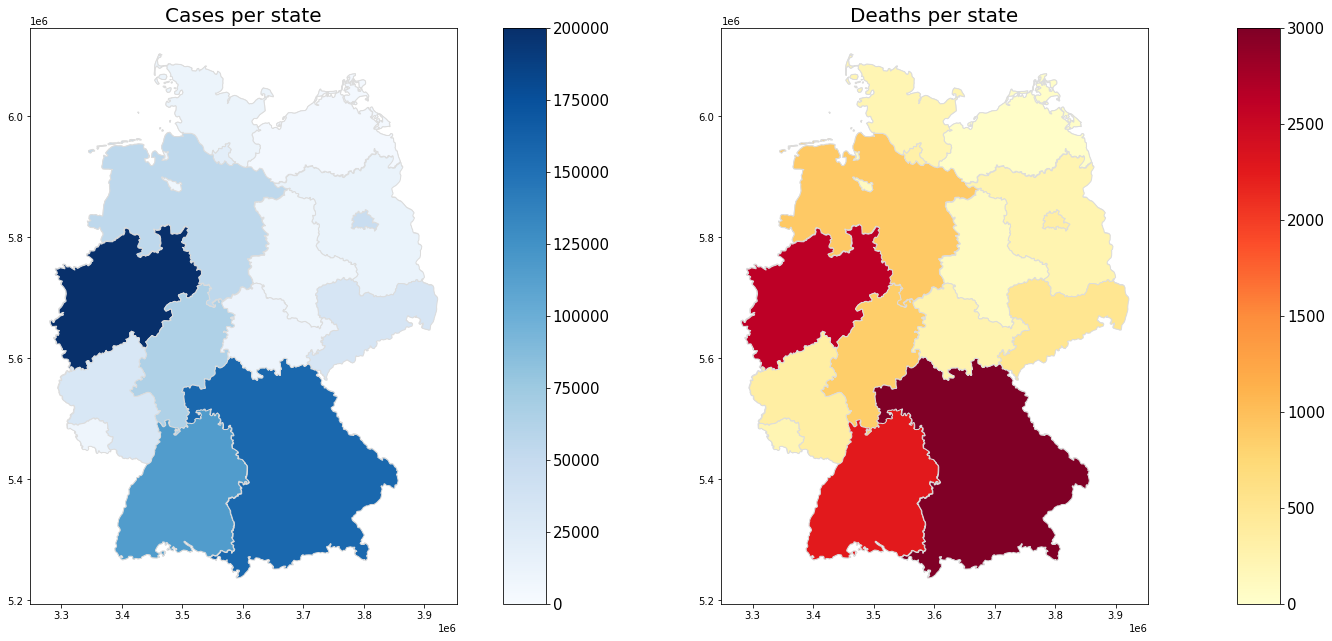

In [115]:
norm_axis1 = 200e3
norm_axis2 = 3e3

def add_case_per_state(state):
    case = covid_de.loc[covid_de['state'] == state ].cases.sum()
    #print(case)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.Blues(case/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

def add_death_per_state(state):
    death = covid_de.loc[covid_de['state'] == state ].deaths.sum()
    #print(death)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.YlOrRd(death/norm_axis2), edgecolor='gainsboro', zorder=3, ax = ax2)

plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_case_per_state(i)
ax1.set_title('Cases per state', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='Blues')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_death_per_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='YlOrRd')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Deaths per state', fontsize=20)

plt.show()

# Fälle normalisiert auf Bevölkerung

Fälle und Todesfälle treten hauptsächlich in dicht besiedelten Staaten auf. Im Folgenden kann die Normalisierung pro Bevölkerung und Bevölkerungsdichte überprüfen. Interessant ist auch, dass der östliche Teil Deutschlands viel weniger betroffen ist als der westliche Teil.

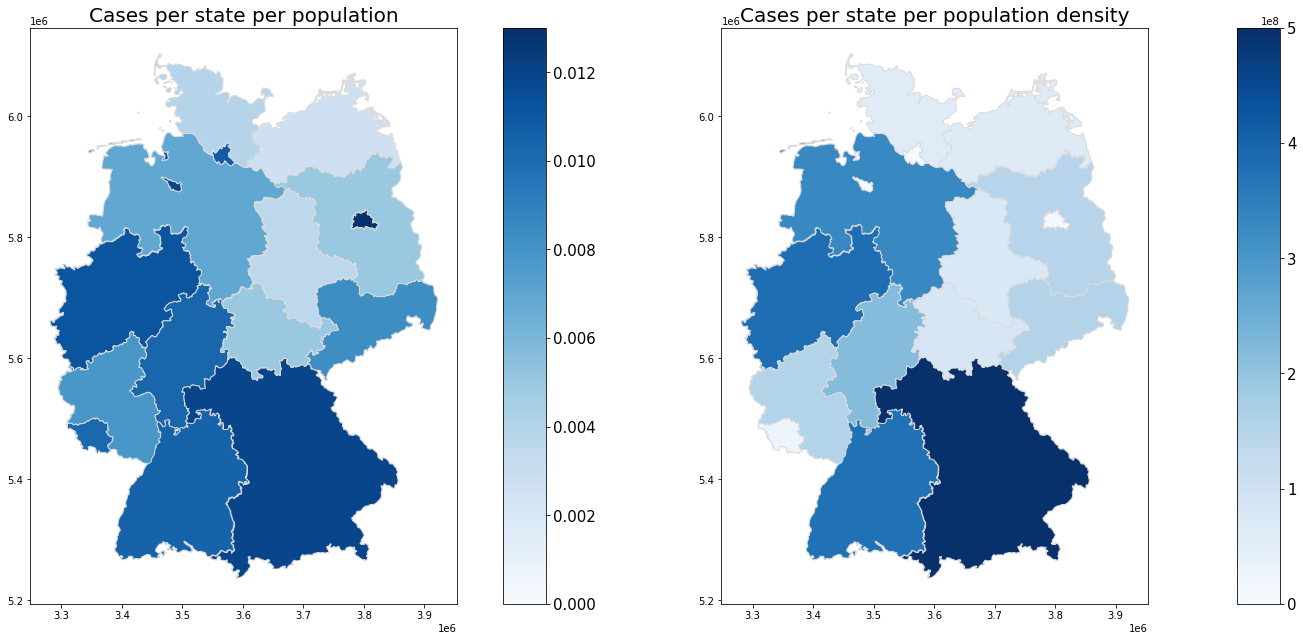

In [116]:
norm_axis1 = 0.013
norm_axis2 = 5e8


def add_case_per_pop_state(state):
    case_norm = covid_de.loc[covid_de['state'] == state ].cases.sum() / demo_de[demo_de.state == state].population.sum()
    #print(case_norm)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.Blues(case_norm/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

def get_area(state):   
    return shape_de[shape_de.state == state].geometry.area
    
def add_case_per_dens_state(state):
    case_dens = covid_de.loc[covid_de['state'] == state ].cases.sum() / (demo_de[demo_de.state == state].population.sum()/float(get_area(state)))
    #print(case_dens)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.Blues(case_dens/norm_axis2), edgecolor='gainsboro', zorder=3, ax =  ax2)

    

plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_case_per_pop_state(i)
ax1.set_title('Cases per state per population', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='Blues')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_case_per_dens_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='Blues')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Cases per state per population density', fontsize=20)

plt.show()

In [117]:
print('Age 60-79-------------')
print(covid_de[covid_de.age_group == '60-79'].groupby('state').cases.sum() /  covid_de.groupby('state').cases.sum() )
print('Age 80-99-------------')
print(covid_de[covid_de.age_group == '80-99'].groupby('state').cases.sum() /  covid_de.groupby('state').cases.sum() )

Age 60-79-------------
state
Baden-Wuerttemberg        0.146786
Bayern                    0.143379
Berlin                    0.106300
Brandenburg               0.178427
Bremen                    0.108317
Hamburg                   0.111606
Hessen                    0.124177
Mecklenburg-Vorpommern    0.188310
Niedersachsen             0.129881
Nordrhein-Westfalen       0.125923
Rheinland-Pfalz           0.137730
Saarland                  0.168960
Sachsen                   0.202871
Sachsen-Anhalt            0.175271
Schleswig-Holstein        0.139248
Thueringen                0.205672
Name: cases, dtype: float64
Age 80-99-------------
state
Baden-Wuerttemberg        0.070847
Bayern                    0.067274
Berlin                    0.043341
Brandenburg               0.082759
Bremen                    0.041217
Hamburg                   0.055628
Hessen                    0.055143
Mecklenburg-Vorpommern    0.060496
Niedersachsen             0.062997
Nordrhein-Westfalen       0.054468
Rhei

In [118]:
#printout 'hot-spots'

for i in covid_de.county.unique():
    if (covid_de[covid_de.county == i].cases.sum()) > 800:
        print(covid_de[covid_de.county == i].state.unique() , '-----',i,'----',covid_de[covid_de.county == i].cases.sum())

['Baden-Wuerttemberg'] ----- LK Alb-Donau-Kreis ---- 2172
['Baden-Wuerttemberg'] ----- LK Biberach ---- 1484
['Baden-Wuerttemberg'] ----- LK Boeblingen ---- 5077
['Baden-Wuerttemberg'] ----- LK Bodenseekreis ---- 1238
['Baden-Wuerttemberg'] ----- LK Breisgau-Hochschwarzwald ---- 2796
['Baden-Wuerttemberg'] ----- LK Calw ---- 1815
['Baden-Wuerttemberg'] ----- LK Emmendingen ---- 1712
['Baden-Wuerttemberg'] ----- LK Enzkreis ---- 2055
['Baden-Wuerttemberg'] ----- LK Esslingen ---- 6654
['Baden-Wuerttemberg'] ----- LK Freudenstadt ---- 1229
['Baden-Wuerttemberg'] ----- LK Goeppingen ---- 2932
['Baden-Wuerttemberg'] ----- LK Heidenheim ---- 1367
['Baden-Wuerttemberg'] ----- LK Heilbronn ---- 3406
['Baden-Wuerttemberg'] ----- LK Hohenlohekreis ---- 1346
['Baden-Wuerttemberg'] ----- LK Karlsruhe ---- 4002
['Baden-Wuerttemberg'] ----- LK Konstanz ---- 2231
['Baden-Wuerttemberg'] ----- LK Loerrach ---- 2367
['Baden-Wuerttemberg'] ----- LK Ludwigsburg ---- 7253
['Baden-Wuerttemberg'] ----- LK M

['Niedersachsen'] ----- SK Braunschweig ---- 1266
['Niedersachsen'] ----- SK Delmenhorst ---- 1051
['Niedersachsen'] ----- SK Oldenburg ---- 855
['Niedersachsen'] ----- SK Osnabrueck ---- 1578
['Niedersachsen'] ----- SK Salzgitter ---- 955
['Nordrhein-Westfalen'] ----- LK Borken ---- 3656
['Nordrhein-Westfalen'] ----- LK Coesfeld ---- 1721
['Nordrhein-Westfalen'] ----- LK Dueren ---- 3537
['Nordrhein-Westfalen'] ----- LK Ennepe-Ruhr-Kreis ---- 2993
['Nordrhein-Westfalen'] ----- LK Euskirchen ---- 1822
['Nordrhein-Westfalen'] ----- LK Guetersloh ---- 5753
['Nordrhein-Westfalen'] ----- LK Heinsberg ---- 3552
['Nordrhein-Westfalen'] ----- LK Herford ---- 2561
['Nordrhein-Westfalen'] ----- LK Hochsauerlandkreis ---- 2419
['Nordrhein-Westfalen'] ----- LK Hoexter ---- 1014
['Nordrhein-Westfalen'] ----- LK Kleve ---- 2713
['Nordrhein-Westfalen'] ----- LK Lippe ---- 3106
['Nordrhein-Westfalen'] ----- LK Maerkischer Kreis ---- 3834
['Nordrhein-Westfalen'] ----- LK Mettmann ---- 5731
['Nordrhein

# Zeitabhängigkeit

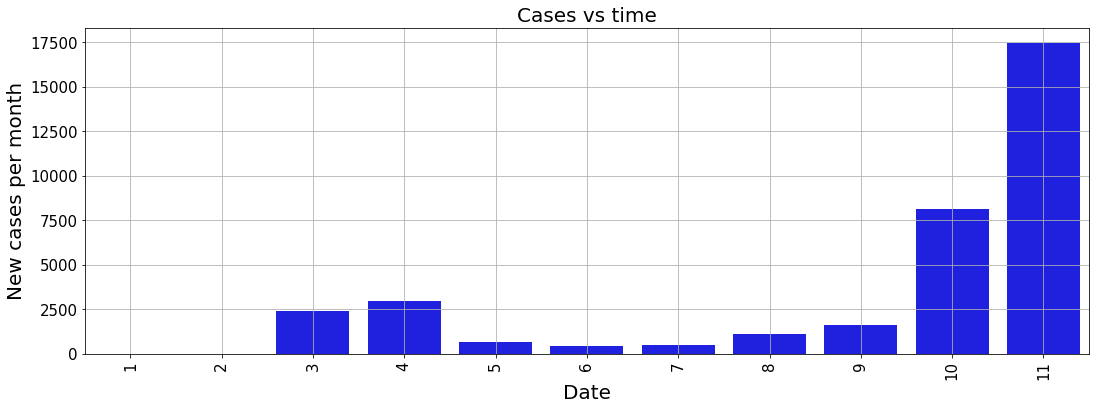

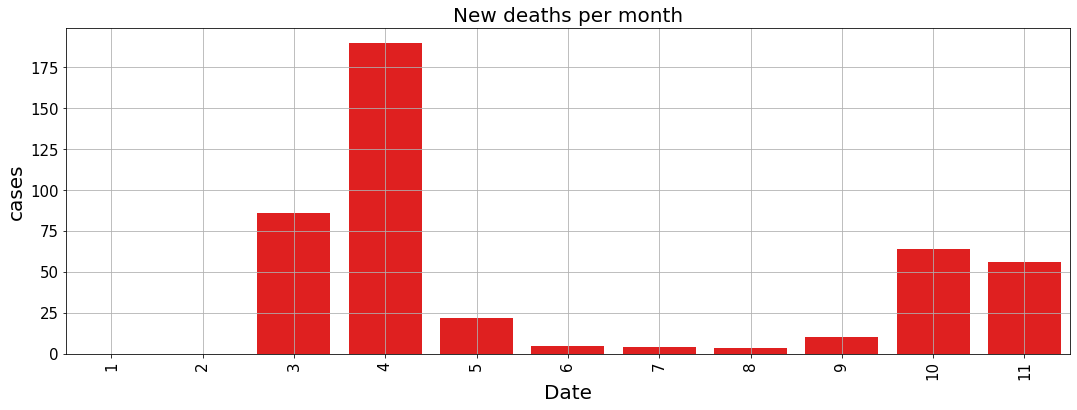

In [140]:
date_comp   = covid_de.index.map(pd.Timestamp).unique().sort_values()
case_diff   = covid_de.groupby('date').cases.sum()
deaths_diff = covid_de.groupby('date').deaths.sum()
date_month= date_comp.month


plt.figure(figsize=(18,6))
ax4 = sns.barplot(x=date_month, y= case_diff, color = 'blue', ci=None)
ax4.set_xticklabels(labels=ax4.get_xticklabels(),rotation=90)
plt.ylabel('New cases per month', fontsize=20)
plt.xlabel('Date', fontsize=20)
ax4.set_title('Cases vs time', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.figure(figsize=(18,6))
ax5 = sns.barplot(x=date_month, y= deaths_diff, color = 'red', ci=None)
ax5.set_xticklabels(labels=ax4.get_xticklabels(),rotation=90)
ax5.set_title('New deaths per month', fontsize=20)
plt.ylabel('cases', fontsize=20)
plt.xlabel('Date', fontsize=20)
ax5.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)